# Kalman滤波器 - 代码实现与可视化

本notebook通过具体示例演示Kalman滤波器的实现和应用。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False

np.random.seed(42)

## 1. Kalman滤波器类实现

实现一个通用的Kalman滤波器类，包含预测和更新两个核心步骤。

In [2]:
class KalmanFilter:
    """
    通用Kalman滤波器实现
    
    状态方程: x_k = F @ x_{k-1} + B @ u_{k-1} + w_{k-1}
    观测方程: z_k = H @ x_k + v_k
    
    其中:
    - w_k ~ N(0, Q): 过程噪声
    - v_k ~ N(0, R): 观测噪声
    """
    
    def __init__(self, F, H, Q, R, B=None, x0=None, P0=None):
        """
        初始化Kalman滤波器
        
        参数:
            F: 状态转移矩阵 (n x n)
            H: 观测矩阵 (m x n)
            Q: 过程噪声协方差 (n x n)
            R: 观测噪声协方差 (m x m)
            B: 控制输入矩阵 (n x p), 可选
            x0: 初始状态估计 (n x 1)
            P0: 初始误差协方差 (n x n)
        """
        self.F = np.array(F)
        self.H = np.array(H)
        self.Q = np.array(Q)
        self.R = np.array(R)
        self.B = np.array(B) if B is not None else None
        
        self.n = self.F.shape[0]  # 状态维度
        self.m = self.H.shape[0]  # 观测维度
        
        # 初始化状态和协方差
        self.x = np.zeros((self.n, 1)) if x0 is None else np.array(x0).reshape(-1, 1)
        self.P = np.eye(self.n) if P0 is None else np.array(P0)
        
        # 存储历史记录
        self.x_history = [self.x.copy()]
        self.P_history = [self.P.copy()]
        self.K_history = []
        self.innovation_history = []
    
    def predict(self, u=None):
        """
        预测步骤 (Time Update)
        
        x_k^- = F @ x_{k-1} + B @ u_{k-1}
        P_k^- = F @ P_{k-1} @ F^T + Q
        """
        # 状态预测
        self.x = self.F @ self.x
        if self.B is not None and u is not None:
            self.x += self.B @ np.array(u).reshape(-1, 1)
        
        # 协方差预测
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        return self.x.copy(), self.P.copy()
    
    def update(self, z):
        """
        更新步骤 (Measurement Update)
        
        K_k = P_k^- @ H^T @ (H @ P_k^- @ H^T + R)^{-1}
        x_k = x_k^- + K_k @ (z_k - H @ x_k^-)
        P_k = (I - K_k @ H) @ P_k^-
        """
        z = np.array(z).reshape(-1, 1)
        
        # 计算新息 (Innovation)
        innovation = z - self.H @ self.x
        
        # 新息协方差
        S = self.H @ self.P @ self.H.T + self.R
        
        # Kalman增益
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # 状态更新
        self.x = self.x + K @ innovation
        
        # 协方差更新 (Joseph形式，数值更稳定)
        I_KH = np.eye(self.n) - K @ self.H
        self.P = I_KH @ self.P @ I_KH.T + K @ self.R @ K.T
        
        # 保存历史
        self.x_history.append(self.x.copy())
        self.P_history.append(self.P.copy())
        self.K_history.append(K.copy())
        self.innovation_history.append(innovation.copy())
        
        return self.x.copy(), self.P.copy(), K.copy()
    
    def filter(self, z, u=None):
        """执行一次完整的预测-更新循环"""
        self.predict(u)
        return self.update(z)

## 2. 示例1: 一维位置估计

考虑一个简单的一维运动目标跟踪问题：
- 状态: 位置 $x$
- 观测: 带噪声的位置测量
- 真实位置恒定为10

In [3]:
# 系统参数
true_position = 10.0  # 真实位置
n_steps = 50

# 状态空间模型 (一维静态系统)
F = np.array([[1.0]])  # 状态转移: x_k = x_{k-1}
H = np.array([[1.0]])  # 观测: z_k = x_k + v_k
Q = np.array([[0.01]]) # 过程噪声很小
R = np.array([[4.0]])  # 观测噪声方差为4 (标准差为2)

# 初始化
x0 = np.array([[0.0]])  # 初始估计为0
P0 = np.array([[100.0]]) # 初始不确定性很大

# 创建滤波器
kf = KalmanFilter(F, H, Q, R, x0=x0, P0=P0)

# 生成观测数据
observations = true_position + np.sqrt(R[0,0]) * np.random.randn(n_steps)

# 运行滤波器
estimates = []
variances = []

for z in observations:
    x_est, P_est, _ = kf.filter(z)
    estimates.append(x_est[0, 0])
    variances.append(P_est[0, 0])

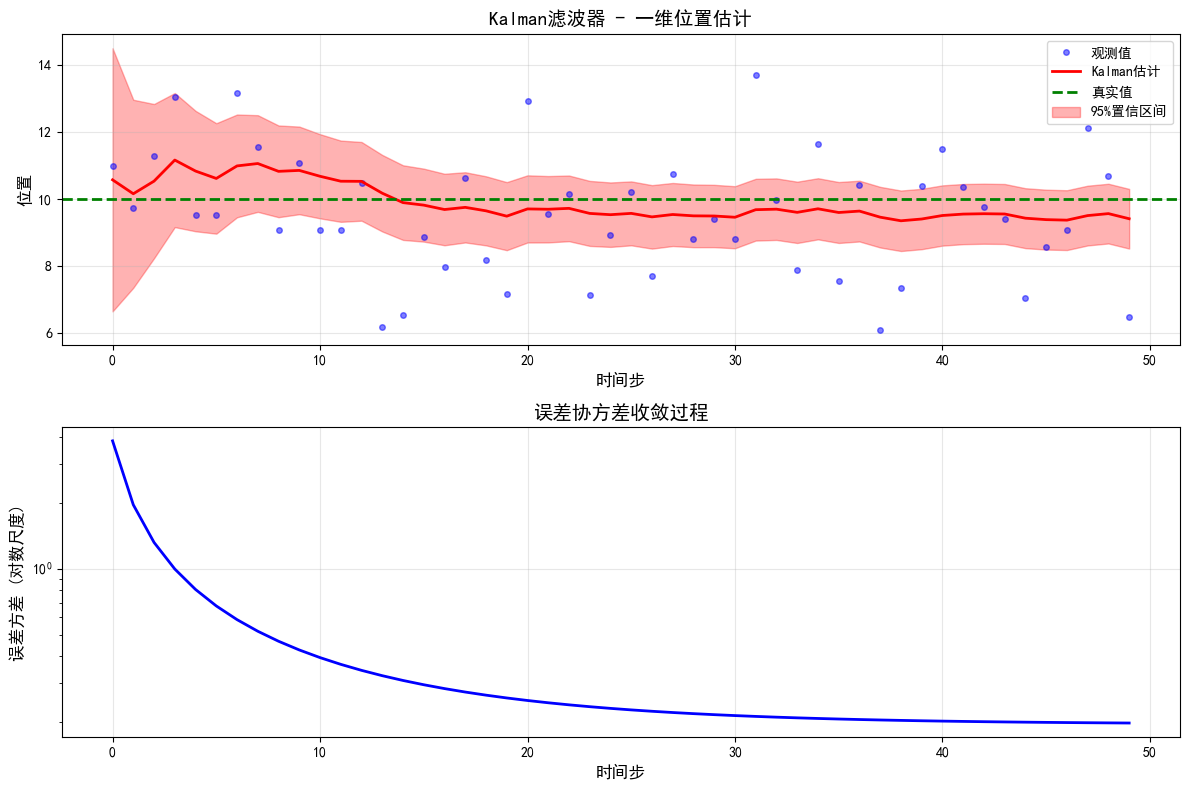

最终估计值: 9.4103
真实值: 10.0
最终估计误差: 0.5897
最终估计标准差: 0.4447


In [4]:
# 可视化结果
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 图1: 状态估计
ax1 = axes[0]
ax1.plot(observations, 'b.', alpha=0.5, label='观测值', markersize=8)
ax1.plot(estimates, 'r-', linewidth=2, label='Kalman估计')
ax1.axhline(y=true_position, color='g', linestyle='--', linewidth=2, label='真实值')

# 绘制置信区间 (±2σ)
std = np.sqrt(variances)
ax1.fill_between(range(n_steps), 
                  np.array(estimates) - 2*std, 
                  np.array(estimates) + 2*std, 
                  alpha=0.3, color='red', label='95%置信区间')

ax1.set_xlabel('时间步', fontsize=12)
ax1.set_ylabel('位置', fontsize=12)
ax1.set_title('Kalman滤波器 - 一维位置估计', fontsize=14)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 图2: 估计误差协方差收敛
ax2 = axes[1]
ax2.semilogy(variances, 'b-', linewidth=2)
ax2.set_xlabel('时间步', fontsize=12)
ax2.set_ylabel('误差方差 (对数尺度)', fontsize=12)
ax2.set_title('误差协方差收敛过程', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"最终估计值: {estimates[-1]:.4f}")
print(f"真实值: {true_position}")
print(f"最终估计误差: {abs(estimates[-1] - true_position):.4f}")
print(f"最终估计标准差: {np.sqrt(variances[-1]):.4f}")

## 3. 示例2: 二维目标跟踪 (位置+速度)

跟踪一个匀速运动的目标：
- 状态: $\mathbf{x} = [x, \dot{x}]^T$ (位置和速度)
- 观测: 只能观测位置

In [5]:
# 系统参数
dt = 0.1  # 采样间隔
n_steps = 100

# 真实轨迹: 初始位置0, 速度2
true_velocity = 2.0
true_positions = np.array([true_velocity * dt * i for i in range(n_steps)])

# 状态空间模型
# 状态: [位置, 速度]^T
# x_k = F @ x_{k-1}, 其中 F = [[1, dt], [0, 1]]
F = np.array([[1, dt],
              [0, 1]])

# 只观测位置
H = np.array([[1, 0]])

# 过程噪声 (加速度扰动)
q = 0.1  # 加速度噪声强度
Q = q * np.array([[dt**4/4, dt**3/2],
                  [dt**3/2, dt**2]])

# 观测噪声
R = np.array([[1.0]])

# 初始化
x0 = np.array([[0], [0]])  # 初始估计: 位置0, 速度0
P0 = np.array([[10, 0],
               [0, 10]])  # 初始不确定性

# 创建滤波器
kf2d = KalmanFilter(F, H, Q, R, x0=x0, P0=P0)

# 生成观测数据
observations = true_positions + np.sqrt(R[0,0]) * np.random.randn(n_steps)

# 运行滤波器
pos_estimates = []
vel_estimates = []
pos_variances = []
vel_variances = []

for z in observations:
    x_est, P_est, _ = kf2d.filter(z)
    pos_estimates.append(x_est[0, 0])
    vel_estimates.append(x_est[1, 0])
    pos_variances.append(P_est[0, 0])
    vel_variances.append(P_est[1, 1])

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


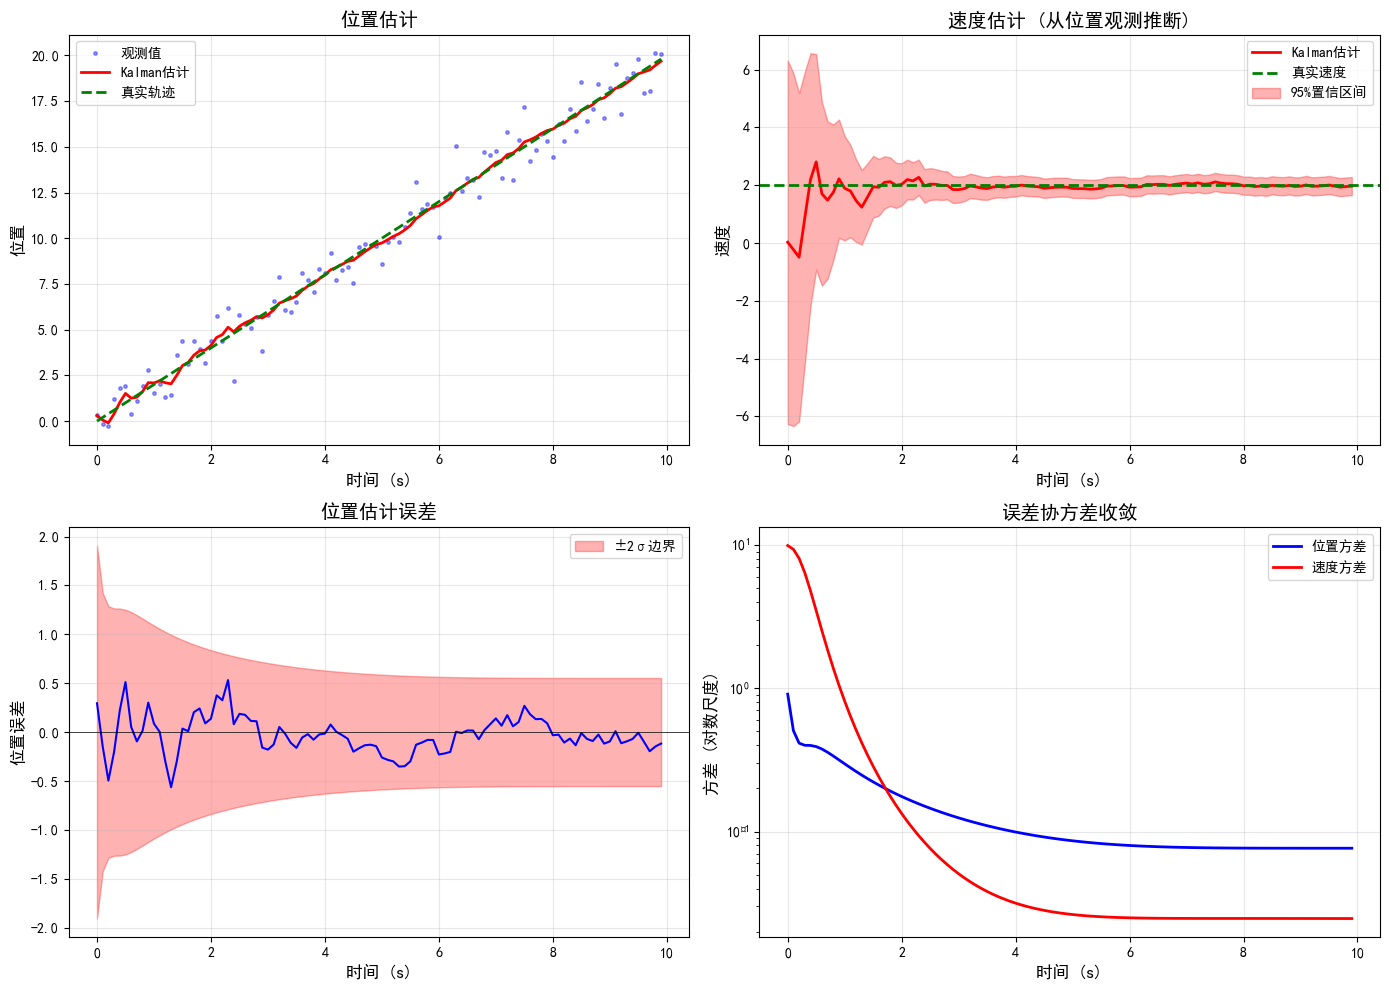

最终速度估计: 1.9690
真实速度: 2.0
速度估计误差: 0.0310


In [6]:
# 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

time = np.arange(n_steps) * dt

# 图1: 位置估计
ax1 = axes[0, 0]
ax1.plot(time, observations, 'b.', alpha=0.4, label='观测值', markersize=5)
ax1.plot(time, pos_estimates, 'r-', linewidth=2, label='Kalman估计')
ax1.plot(time, true_positions, 'g--', linewidth=2, label='真实轨迹')
ax1.set_xlabel('时间 (s)', fontsize=12)
ax1.set_ylabel('位置', fontsize=12)
ax1.set_title('位置估计', fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 图2: 速度估计
ax2 = axes[0, 1]
ax2.plot(time, vel_estimates, 'r-', linewidth=2, label='Kalman估计')
ax2.axhline(y=true_velocity, color='g', linestyle='--', linewidth=2, label='真实速度')
std_vel = np.sqrt(vel_variances)
ax2.fill_between(time, 
                  np.array(vel_estimates) - 2*std_vel, 
                  np.array(vel_estimates) + 2*std_vel, 
                  alpha=0.3, color='red', label='95%置信区间')
ax2.set_xlabel('时间 (s)', fontsize=12)
ax2.set_ylabel('速度', fontsize=12)
ax2.set_title('速度估计 (从位置观测推断)', fontsize=14)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# 图3: 位置估计误差
ax3 = axes[1, 0]
pos_error = np.array(pos_estimates) - true_positions
ax3.plot(time, pos_error, 'b-', linewidth=1.5)
std_pos = np.sqrt(pos_variances)
ax3.fill_between(time, -2*std_pos, 2*std_pos, alpha=0.3, color='red', label='±2σ边界')
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax3.set_xlabel('时间 (s)', fontsize=12)
ax3.set_ylabel('位置误差', fontsize=12)
ax3.set_title('位置估计误差', fontsize=14)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# 图4: 协方差收敛
ax4 = axes[1, 1]
ax4.semilogy(time, pos_variances, 'b-', linewidth=2, label='位置方差')
ax4.semilogy(time, vel_variances, 'r-', linewidth=2, label='速度方差')
ax4.set_xlabel('时间 (s)', fontsize=12)
ax4.set_ylabel('方差 (对数尺度)', fontsize=12)
ax4.set_title('误差协方差收敛', fontsize=14)
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"最终速度估计: {vel_estimates[-1]:.4f}")
print(f"真实速度: {true_velocity}")
print(f"速度估计误差: {abs(vel_estimates[-1] - true_velocity):.4f}")

## 4. Kalman增益的演化分析

观察Kalman增益如何随时间变化，以及它如何平衡预测和观测。

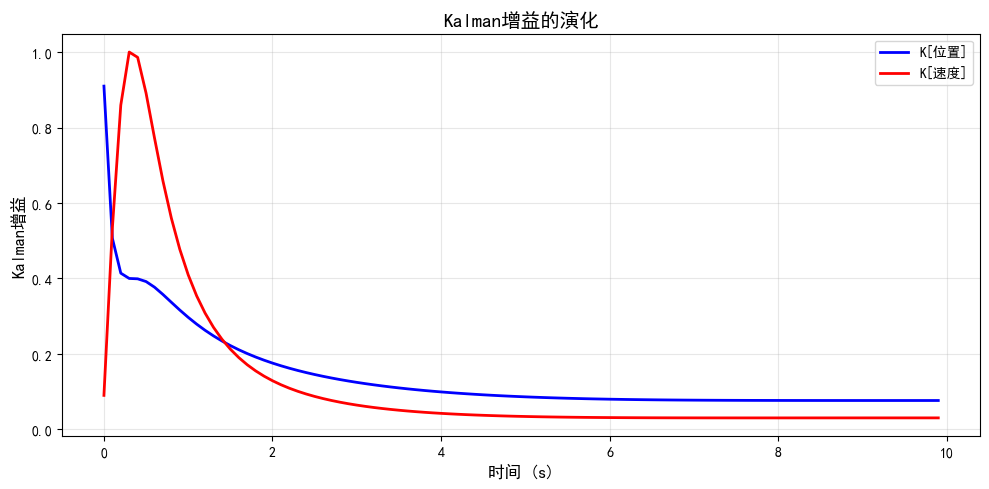


分析:
初始Kalman增益: K_pos=0.9099, K_vel=0.0901
稳态Kalman增益: K_pos=0.0765, K_vel=0.0304

初始时增益较大，因为初始不确定性大，更信任观测
随着估计收敛，增益减小，更信任预测模型


In [7]:
# 提取Kalman增益历史
K_history = np.array([K.flatten() for K in kf2d.K_history])

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(time, K_history[:, 0], 'b-', linewidth=2, label='K[位置]')
ax.plot(time, K_history[:, 1], 'r-', linewidth=2, label='K[速度]')
ax.set_xlabel('时间 (s)', fontsize=12)
ax.set_ylabel('Kalman增益', fontsize=12)
ax.set_title('Kalman增益的演化', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n分析:")
print(f"初始Kalman增益: K_pos={K_history[0,0]:.4f}, K_vel={K_history[0,1]:.4f}")
print(f"稳态Kalman增益: K_pos={K_history[-1,0]:.4f}, K_vel={K_history[-1,1]:.4f}")
print("\n初始时增益较大，因为初始不确定性大，更信任观测")
print("随着估计收敛，增益减小，更信任预测模型")

## 5. 不同噪声参数的影响

比较不同Q和R设置对滤波效果的影响。

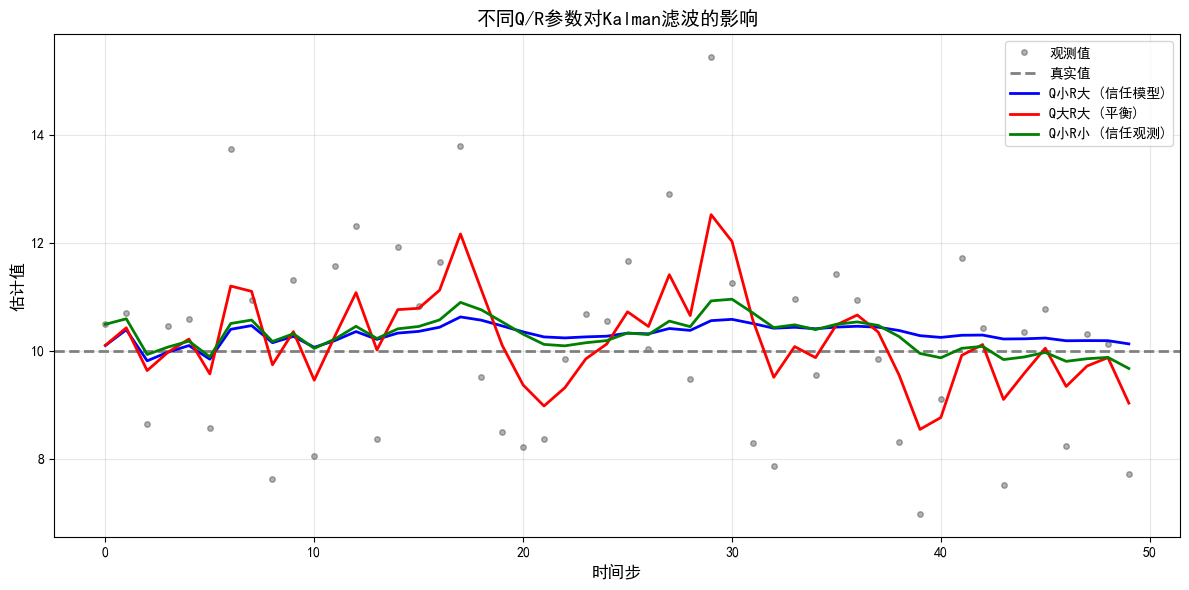


参数影响分析:
- Q小R大: 滤波器认为模型准确，观测噪声大，估计变化缓慢
- Q大R大: 平衡模型和观测，适度响应
- Q小R小: 滤波器认为观测准确，快速跟踪观测值


In [8]:
def run_kalman_1d(Q_val, R_val, observations, true_val):
    """运行一维Kalman滤波器"""
    F = np.array([[1.0]])
    H = np.array([[1.0]])
    Q = np.array([[Q_val]])
    R = np.array([[R_val]])
    
    kf = KalmanFilter(F, H, Q, R, x0=[[0]], P0=[[100]])
    
    estimates = []
    for z in observations:
        x_est, _, _ = kf.filter(z)
        estimates.append(x_est[0, 0])
    
    return estimates

# 生成观测
true_val = 10.0
n_steps = 50
obs_noise_std = 2.0
observations = true_val + obs_noise_std * np.random.randn(n_steps)

# 不同参数设置
configs = [
    {'Q': 0.001, 'R': 4.0, 'label': 'Q小R大 (信任模型)'},
    {'Q': 1.0, 'R': 4.0, 'label': 'Q大R大 (平衡)'},
    {'Q': 0.001, 'R': 0.1, 'label': 'Q小R小 (信任观测)'},
]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(observations, 'k.', alpha=0.3, label='观测值', markersize=8)
ax.axhline(y=true_val, color='gray', linestyle='--', linewidth=2, label='真实值')

colors = ['blue', 'red', 'green']
for config, color in zip(configs, colors):
    estimates = run_kalman_1d(config['Q'], config['R'], observations, true_val)
    ax.plot(estimates, color=color, linewidth=2, label=config['label'])

ax.set_xlabel('时间步', fontsize=12)
ax.set_ylabel('估计值', fontsize=12)
ax.set_title('不同Q/R参数对Kalman滤波的影响', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n参数影响分析:")
print("- Q小R大: 滤波器认为模型准确，观测噪声大，估计变化缓慢")
print("- Q大R大: 平衡模型和观测，适度响应")
print("- Q小R小: 滤波器认为观测准确，快速跟踪观测值")

## 6. 总结

### Kalman滤波器的关键特性:

1. **递归性**: 只需保存上一时刻的估计，不需要存储所有历史数据
2. **最优性**: 在线性高斯假设下，给出MMSE最优估计
3. **自适应性**: Kalman增益自动调整预测和观测的权重
4. **收敛性**: 误差协方差通常会收敛到稳态值

### 参数调节建议:

- **Q (过程噪声)**: 反映模型的不确定性，Q大则更信任观测
- **R (观测噪声)**: 反映观测的不确定性，R大则更信任模型
- **P0 (初始协方差)**: 反映初始估计的不确定性，通常设置较大值